# Chapter 7. 머신러닝 데이터 분석

## 3. 분류
* 입력 데이터: 대상의 속성
* 출력 데이터: 카테고리(범주형) 값 중에서 어느 한 값을 예측
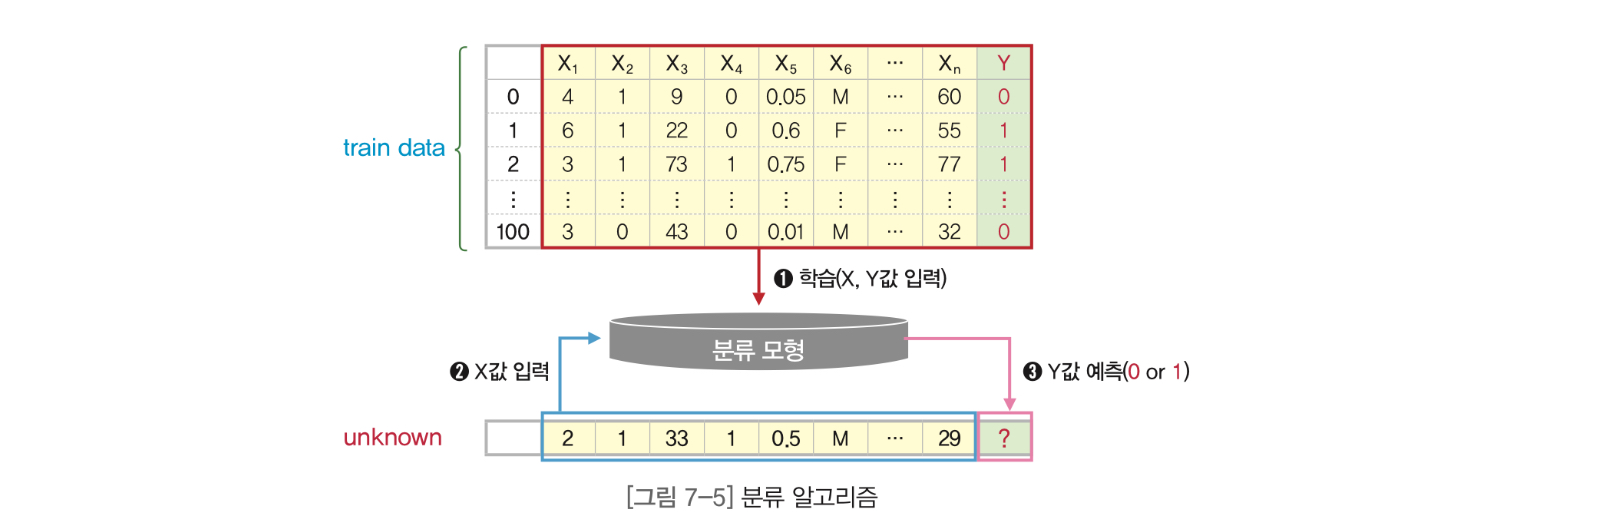
* 고객 분류, 질병 진단, 스팸 메일 필터링, 음성 인식 등 목표 변수가 카테고리 값을 갖는 경우에 사용
* KNN, SVM, Decision Tree, Logistic Regression 등

### 3-1. KNN
* K-Nearest-Neighbors
* 새로운 데이터가 입력되면 기존 데이터 중 가장 속성이 비슷한 k의 이웃을 먼저 찾음 -> 가까운 이웃들이 갖고 있는 목표 값과 같은 값으로 분류 예측
* k 값에 따라 예측의 정확도가 달라지므로, 적절한 k값을 찾는 것이 중요
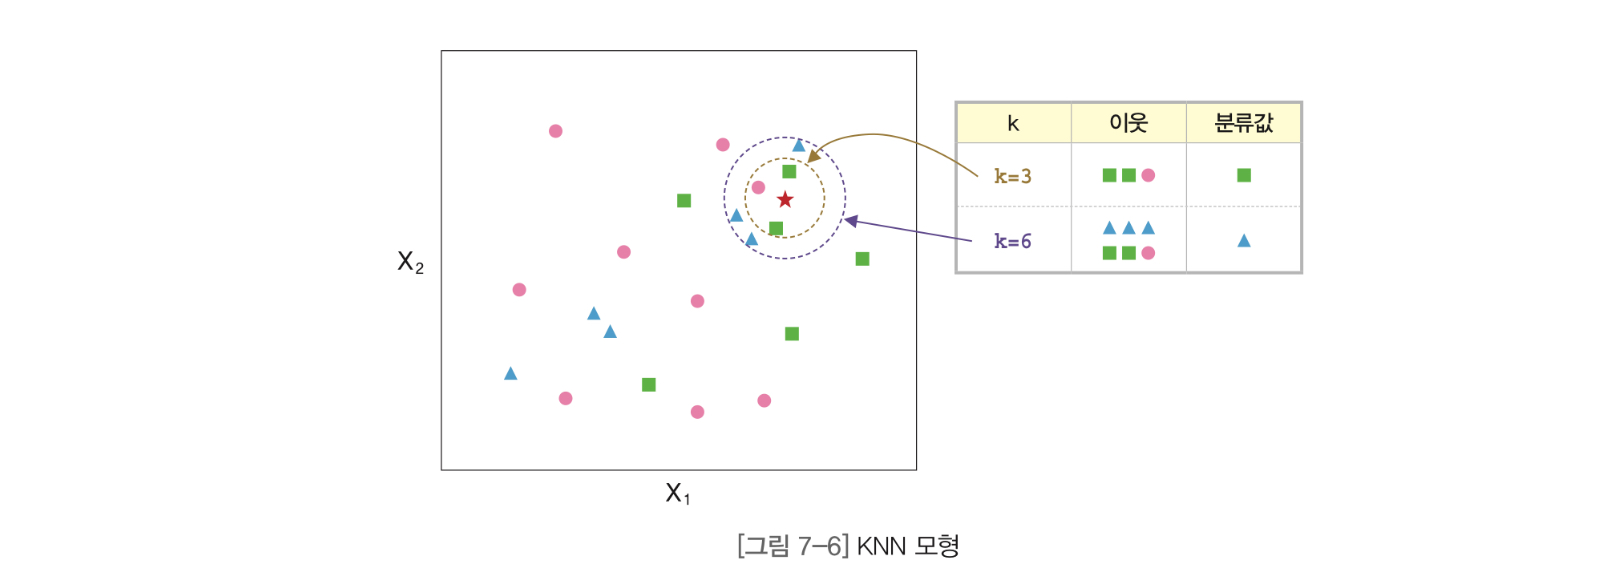

#### 1. 데이터 준비

In [48]:
import pandas as pd
import seaborn as sns
import numpy as np

In [7]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
pd.set_option('display.max_columns', 15)
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### 2. 데이터 탐색

In [11]:
# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제

rdf = df.drop(['deck', 'embark_town'], axis=1) 

In [12]:
# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)

rdf = rdf.dropna(subset=['age'], how='any', axis=0)

In [13]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기

most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

#### 3. 분석에 사용할 속성을 선택

In [14]:
# 분석에 활용할 열(속성)을 선택 

ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

In [15]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

#### 4. 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [16]:
# 속성(변수) 선택
X=ndf.drop('survived', axis=1)  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


#### 5. KNN 분류 모형 - sklearn 사용

In [17]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5로 설정)
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [20]:
# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test, y_hat)            
print(knn_report)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       125
           1       0.80      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215



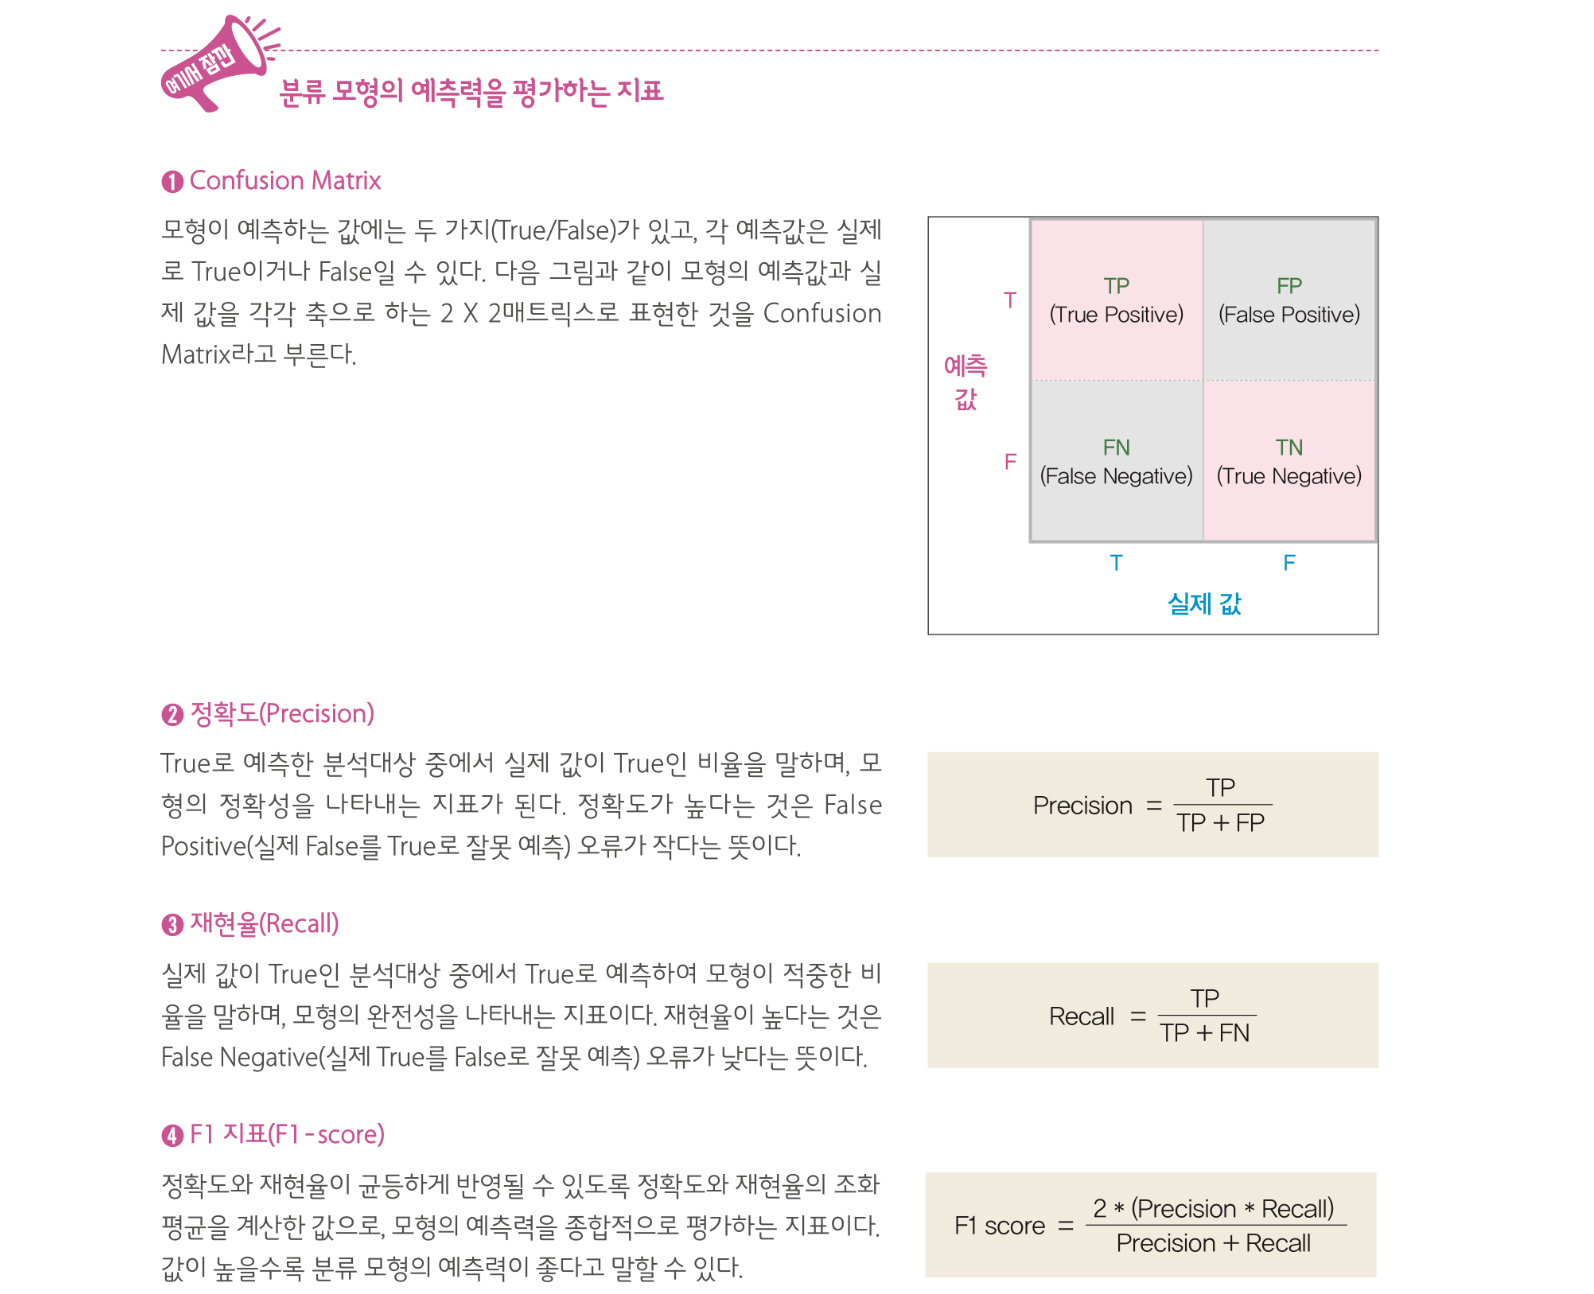

--------

### 3-2. SVM

* Support Vector Machine
* 여러 속성을 나타내는 데이터프레임의 각 열을 열 벡터 형태로 구성
* 속성이 2개면 2차원 공간에 좌표 표시, 3개면 3차원 n개면 n차원 공간에 좌표 표시
* 벡터 공간에 위치한 훈련 데이터의 좌표와 각 데이터가 어떤 분류값을 가졌는지(정답 데이터)를 입력 받아 학습
* 같은 분류 값을 가진 데이터끼리 같은 공간에 위치하도록 벡터 공간을 여러 조각으로 분할
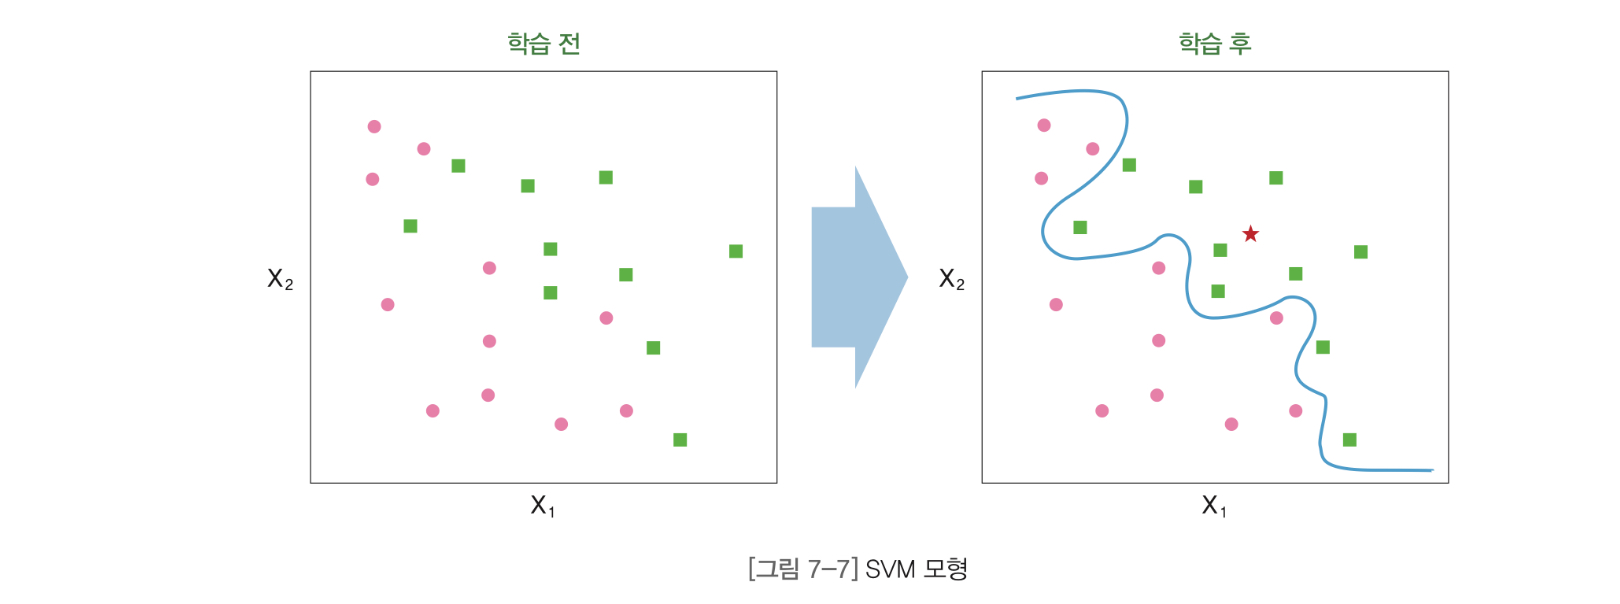

#### 4. 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [33]:
# 속성(변수) 선택
X=ndf.drop('survived', axis=1)  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

In [34]:
# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


#### 5. SVM 분류 모형 - sklearn 사용

In [35]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 0 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [36]:
# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       125
           1       0.92      0.61      0.73        90

    accuracy                           0.81       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.83      0.81      0.81       215



-------------

### 3-3. Decision Tree

* 의사결정 나무
* 트리 구조 / 각 분기점(node)에 속성 위치
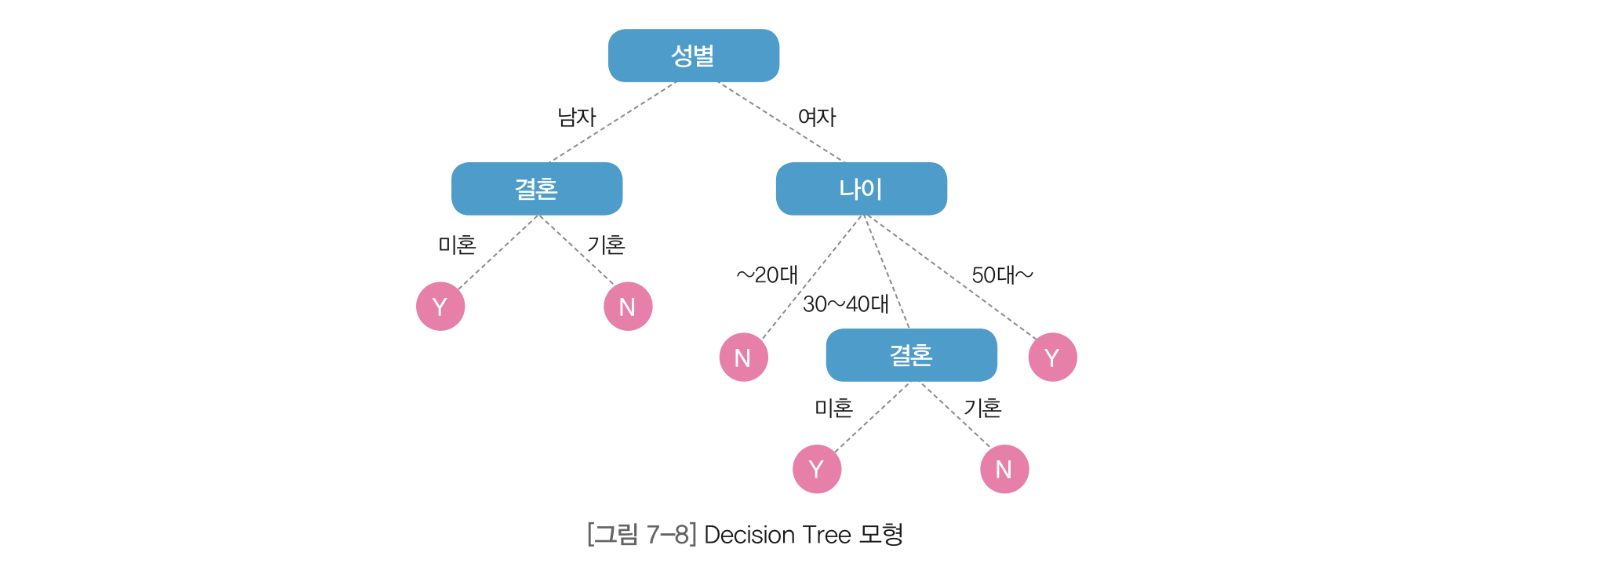

#### 1. 데이터 준비/ 기본 설정

In [51]:
# Breast Cancer 데이터셋 가져오기 (출처: UCI ML Repository)
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(uci_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [52]:
# 열 이름 지정
df.columns = ['id','clump','cell_size','cell_shape', 'adhesion','epithlial',
              'bare_nuclei','chromatin','normal_nucleoli', 'mitoses', 'class'] 

#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


#### 2. 데이터 탐색

In [53]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [54]:
# 데이터 통계 요약정보 확인
df.describe()

,id,clump,cell_size,cell_shape,adhesion,epithlial,chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [55]:
# bare_nuclei 열의 자료형 변경 (문자열 ->숫자)
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [57]:
# '?'을 np.nan으로 변경
df['bare_nuclei'].replace('?', np.nan, inplace=True)      

# 누락데이터 행을 삭제
df.dropna(subset=['bare_nuclei'], axis=0, inplace=True)   

# 문자열을 정수형으로 변환
df['bare_nuclei'] = df['bare_nuclei'].astype('int')

df['bare_nuclei'].unique()

array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6])

#### 3. 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [58]:
# 속성(변수) 선택
X=df.drop('class', axis=1)
y=df['class']

In [59]:
# 설명 변수 데이터를 정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)
print('\n')

train data 개수:  (478, 10)
test data 개수:  (205, 10)




#### 4. Decision Tree 분류 모형 - sklearn 사용

In [61]:
# sklearn 라이브러리에서 Decision Tree 분류 모형 가져오기
from sklearn import tree

# 모형 객체 생성 (criterion='entropy' 적용)
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

# train data를 가지고 모형 학습
tree_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = tree_model.predict(X_test)      # 2: benign(양성), 4: malignant(악성)

print(y_hat[0:10])
print(y_test.values[0:10])

[4 4 4 4 4 4 2 2 4 4]
[4 4 4 4 4 4 2 2 4 4]


In [62]:
# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)

              precision    recall  f1-score   support

           2       0.98      0.97      0.98       131
           4       0.95      0.97      0.96        74

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205

